# Example usage of trainer class

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


## Define Dataset
Creating the dataset object and applzing transformations to the data.

In [3]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 1,
    tact_order = 10,
    tact_number=2, 
    rand_rotations=2
    
)
# set regenerate to true, if you run this after changes in dataconverter have been made
#dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


In [4]:
from data.reconstruction_dataset import *

csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<Figure size 640x480 with 0 Axes>

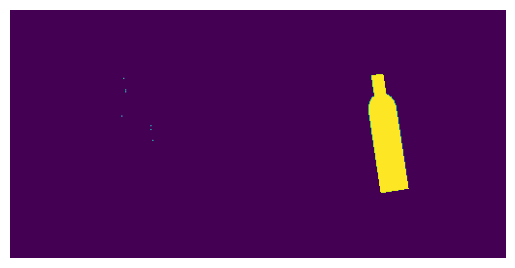

In [5]:
example_data = dataset[5]

plt.figure()
print(example_data['image'])
show_datapair(example_data['image'], example_data['label'])
plt.show()

## Choose Hyperparamters

Look into the file neural_nets.trainer to see which hyperparameters you can choose.
The seperation into tunable and non tunable hyperparameters is made, because this makes parameter searches with ray easier.


#### Non Tunable Hyperparameters


In [6]:
from neural_nets.trainer import NonTHparams


nt_h = NonTHparams()
nt_h.num_epochs = 50
nt_h.train_prop = 0.93 # set way to high to make validation period short and make testing this search easier

nt_h.print_log = True # to better see param search results
nt_h.log_train_period = 100
nt_h.log_val_freq = 5 #int(nt_h.train_prop*len(dataset)/f)-1 #set low to test this parameter search


#### Define Tunable Hyperparameters and parameter spaces for upgrade

The hyperparameters we want to tone have to be put into a list of possible values and that list into a dict, for the hyperparameter optimizer to do its job.

In [ ]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

from neural_nets.trainer import THparams
from neural_nets.weight_inits import weight_init_kx
from neural_nets.models.unet import UNet2


from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

t_h = THparams()
t_h.batch_size = 16

t_h.model = UNet2
t_h.weight_init = weight_init_kx
t_h.depth = 5
t_h.channels = 64

t_h.lr = 1e-4
t_h.optimizer = optim.Adam
t_h.loss_func = nn.BCELoss()


image_resolution = dataset[0]['image'].shape[1]
max_unet_depth = int(np.log2(image_resolution))

# config is the set of params, that will be searched, they got to ghave the same key names, as variables in THparams
config = {
    "batch_size": tune.choice([2 ** i for i in range(2,5)]),
    "lr": tune.loguniform(1e-7, 1e-2),
    "depth": tune.choice([i for i in range(3,max_unet_depth+1-2)]),
    "channels": tune.choice([2 ** i for i in range(4,9)])
}




## Initialize Trainer

In [10]:
from neural_nets.trainer import Trainer

trainer = Trainer(nt_h, t_h, dataset)



During training, progress will be logged to tensorboard. Go to project folder, activate appropritae conda environment and run 'tensorboard --logdir runs/' to see the logs.


## Run Parameter Search

In [ ]:
import ray
import GPUtil

num_samples=40
max_num_epochs=4*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
gpus_per_trial = 1

os.environ["RAY_CHDIR_TO_TRIAL_DIR"] = "0" # needed so that we still can load files using path relative to working directory, 
                                           # as these fuckers change it 
ray.shutdown()
context = ray.init(num_cpus=10)
print("Ray dashboard URL: ", context.dashboard_url)


scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

def tune_func(config):
    tune.utils.wait_for_gpu(target_util=0.2)
    trainer.train_from_dict(config)

result = tune.run(
        tune_func,
        resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,

        raise_on_failed_trial=False,
    )

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")


2024-06-23 02:57:17,908	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-06-23 02:57:18,736	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Ray dashboard URL:  127.0.0.1:8265


(tune_func pid=65008) Hurray! GPU available.
(tune_func pid=65008) Total trainable parameters: 7066113
(tune_func pid=65008) Epoch [1/50], Step [100/1491], Train Loss: 0.6897 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0012
(tune_func pid=65008) Epoch [1/50], Step [200/1491], Train Loss: 0.6811 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0013
(tune_func pid=65008) #######################################################################################
(tune_func pid=65008) Epoch [1/50], Step [6/1491], Val Loss: 0.6603 Val Log Time Proportion: 0.1437
(tune_func pid=65008) #######################################################################################


Trial name,loss,should_checkpoint
tune_func_8a568_00000,0.660303,True


(tune_func pid=65008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_02-57-18/tune_func_8a568_00000_0_batch_size=16,channels=128,depth=3,lr=0.0000_2024-06-23_02-57-19/checkpoint_000000)
2024-06-23 03:04:03,881	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_8a568_00000
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in g

(tune_func pid=65711) Hurray! GPU available.
(tune_func pid=65711) Total trainable parameters: 110913
(tune_func pid=65711) Epoch [1/50], Step [100/5961], Train Loss: 0.6931 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0071
(tune_func pid=65711) Epoch [1/50], Step [200/5961], Train Loss: 0.6930 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0078


In [ ]:
print(result)